In [152]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [153]:
import random as rnd
import functools as func
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [154]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns
import plotly.io as pio
import itertools

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from neuralprophet import NeuralProphet, set_random_seed

In [155]:
T = 2000  #   Количество точек в ряду
T_test = 100   # Количество точек на тест
x = np.arange(0,T)  
N = 100    #  Количество периодов самой частой синусоиды


In [156]:
data_prefix = "M5/"
data_path = "sales_train_evaluation.csv"
data = pd.read_csv(data_path)

In [157]:
df = pd.read_csv('sales_train_validation.csv')
df.head(3)
calendar= pd.read_csv('calendar.csv')

In [158]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [159]:
df.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = df.T  # seting the days as index for new dataframe(Data)
data.columns = df['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calendar['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', length=1913, freq='D')

In [160]:
start_interval = 250 # удаление начального интервала, в котором не отображаются данные о проданном товаре
test_sample= 100
train_LSTNET = data['FOODS_3_090_CA_3_validation'][start_interval:-2*test_sample - 1].astype('float')
test_LSTNET = data['FOODS_3_090_CA_3_validation'][-2*test_sample:-test_sample].astype('float')
true = data['FOODS_3_090_CA_3_validation'][-test_sample:].astype('float')
print('full data length', data[['FOODS_3_090_CA_3_validation']][start_interval:-1].shape)

print('train_LSTNet', train_LSTNET.shape)
print('test_LSTNET', test_LSTNET.shape)
print("true ", true.shape)

full data length (1662, 1)
train_LSTNet (1462,)
test_LSTNET (100,)
true  (100,)


In [161]:
def downcast(df):

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df 

In [162]:
calendar = pd.read_csv("calendar.csv")

In [163]:
calendar = downcast(calendar)

In [164]:
# праздники
lst_events = calendar.event_name_1.dropna().unique().to_list()
events_df = pd.DataFrame(columns = ['event', 'ds'])
for strEvent in lst_events:
    events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[['event_name_1', 'event_name_2']] == strEvent).any(axis=1)].date.unique()
    }))
    
for strEvent in ['snap_CA','snap_TX','snap_WI']:
     events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[strEvent] > 0)].date.unique()
    }))

lst_events.extend(['snap_CA','snap_TX','snap_WI'])

events_df

,event,ds
0,SuperBowl,2011-02-06
1,SuperBowl,2012-02-05
2,SuperBowl,2013-02-03
3,SuperBowl,2014-02-02
4,SuperBowl,2015-02-01
...,...,...
645,snap_WI,2016-06-09
646,snap_WI,2016-06-11
647,snap_WI,2016-06-12
648,snap_WI,2016-06-14


In [165]:
data1 = data.iloc[:,6:]
arr = np.array(data1)
tt = torch.tensor(arr)
print(tt.shape)
tt2=torch.tensor(data1.values)
print(tt2.shape)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
data1 = train_LSTNET
arr = np.array(data1)
tt = torch.tensor(arr)
print(tt.shape)
tt2=torch.tensor(data1.values)
print(tt2.shape)

In [ ]:
data1.shape

In [ ]:
plt.plot(data)
plt.savefig('data1.png')
plt.legend()
plt.show()

In [ ]:
sum(data1.values)

In [ ]:
s = np.array([i for i in map(lambda d: sum(data1.values)/1413.0, data1.values)])
m = np.array([i for i in map(lambda d: max(data1.values), data1.values)])


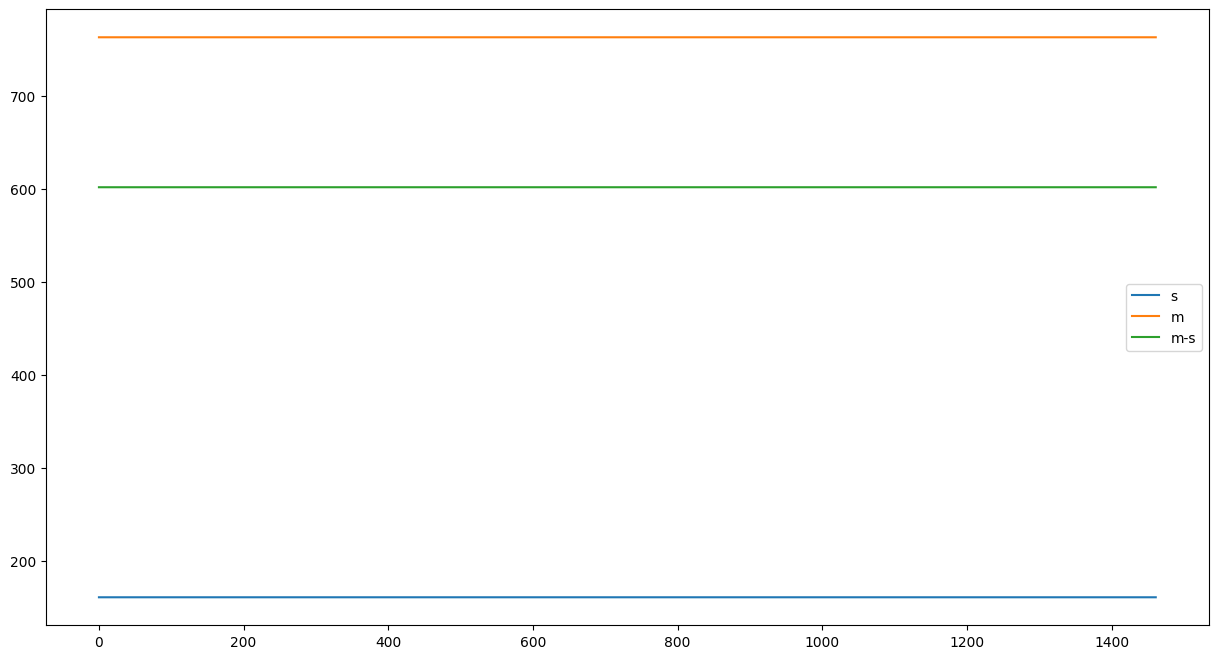

In [166]:
plt.figure(figsize=(15,8))
plt.plot(s, label = "s")
plt.plot(m, label = "m")
plt.plot(m-s, label = "m-s")
plt.savefig('ms_m-s.png')
plt.legend()
plt.show()

In [167]:
data22 = data1[s>10]
data22.shape

ValueError: Item wrong length 1462 instead of 1913.

In [168]:

m1 = m[s>10]
m1.shape

(1462,)

In [169]:
ttsd = torch.tensor(m)     #  Тензор с величинами скачков
ttsp = torch.tensor(s)     #  Тензор с суммарным сдвигом
#ttsp = torch.zeros(all_shifts_prev.shape)
#tts = torch.tensor(all_shifts)
tt2=torch.tensor(m-s)                             #
#tt2 = torch.unsqueeze(torch.tensor(tt2), 1)
#tt2=tt2/(m2t)
#print(tt2.shape)
#print(m2t)
#tt2=tt2.transpose(0,1)
tt2 = torch.stack([tt2, tt2], 1)           #   Данные для предсказания (ряд повторяется два раза, чтобы обойти неизвестный баг)
tts2 = torch.stack([ttsp, ttsd], 1)        #   Общий тензор с внешними регрессорами (сдвигами и скачками)
print(tt2.shape)
print(tts2.shape)
tta = tt2.numpy()                                    #   Ряды данных для предсказания готовим для записи в файл, потому что так хочет лоадер (а вот регрессоры подадим отдельно)
tta[:,1] = tta[:,0]
np.savetxt("M5-lstnet22.txt", tta, delimiter=',')              #   Собственно запись в файл

torch.Size([1462, 2])
torch.Size([1462, 2])


In [170]:
tts2.shape

torch.Size([1462, 2])

In [171]:
tt2=torch.tensor(data1.values)
m2t = torch.unsqueeze(torch.tensor(m1), 1)
tt2=tt2/(m2t)
print(tt2.shape)
print(m2t)
tt2=tt2.transpose(0,-1)
print(tt2.shape)
tta = tt2.numpy()
np.savetxt("M5.txt", tta, delimiter=',')

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [172]:


class Model(nn.Module):
    def __init__(self, args, data, regr_size=0):    #  Добавился последний параметр с количеством рядов-гегрессоров
        super(Model, self).__init__()
        self.use_cuda = args.cuda
        self.P = args.window;
        self.rs = regr_size
        self.m = data.m + regr_size    #  Вот здесь изменение в чужом коде - надо учесть ряды-регрессоры
        self.hidR = args.hidRNN;
        self.hidC = args.hidCNN;
        self.hidS = args.hidSkip;
        self.Ck = args.CNN_kernel;
        self.skip = args.skip;
        self.pt = int((self.P - self.Ck)/self.skip)
        self.hw = args.highway_window
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m - self.rs);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m - self.rs);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
            self.last = nn.Linear(self.m, self.m - self.rs)
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #highway
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            z = self.last(z)
            res = res + z;
            
        if (self.output):
            res = self.output(res);
        return res;

In [173]:
# код с настройкой оптимизаторов 

import math
import torch.optim

class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = torch.optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = torch.optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = torch.optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = torch.optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

In [174]:
#  код с загрузкой данных и формированием батчей для обучения. 

import torch
import numpy as np;
from torch.autograd import Variable


def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))


#  Класс, который загружает данные и формирует батчи. В конструктор дополнительно подаем параметр regressors - тензор с рядами-регрессорами
class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, cuda, horizon, window, regressors, normalize = 2, def_scale = 1):
        self.cuda = cuda;
        self.P = window;
        self.h = horizon
        fin = open(file_name);
        self.rawdat = np.loadtxt(fin,delimiter=',');
        self.regr = regressors                                # Сохраняем сюда ряды-регрессоры
        self.dat = np.zeros(self.rawdat.shape);
        self.n, self.m = self.dat.shape;
        self.normalize = 2
        self.scale = np.ones(self.m)*def_scale;
        self._normalized(normalize);
        self._split(int(train * self.n), int((train+valid) * self.n), self.n);
        
        self.scale = torch.from_numpy(self.scale).float();
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m);
            
        if self.cuda:
            self.scale = self.scale.cuda();
        self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp);
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)));
    
    def _normalized(self, normalize):
        #normalized by the maximum value of entire matrix.
       
        if (normalize == 0):
            self.dat = self.rawdat
            
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat);
            
        #normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]));
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]));
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train);
        valid_set = range(train, valid);
        test_set = range(valid, self.n);
        self.train = self._batchify(train_set, self.h);
        self.valid = self._batchify(valid_set, self.h);
        self.test = self._batchify(test_set, self.h);
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set);
        X = torch.zeros((n,self.P,self.m));
        XR = torch.zeros((n,self.P,self.m));      #   В этом тензоре будут регрессоры
        Y = torch.zeros((n,self.m));
        
        for i in range(n):
            end = idx_set[i] - self.h + 1;
            start = end - self.P;
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :]);
            if (self.regr != None):
                XR[i,:,:] = self.regr[start:end, :];              #  Нарезаем ряды-регрессоры на такие же батчи, как и ряды исходных данных для прогноза
                     
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :]);
            #Y[i,:] = self.regr[idx_set[i], :];
            
        if (self.regr != None):
            X = torch.cat([X, XR], dim=2)           #  Приклеиваем регрессоры к батчам исходных данных

        return [X, Y];

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        #print("len = " + str(length))
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            #print("end_idx = " + str(end_idx))
            excerpt = index[start_idx:end_idx]
            #print("start_idx = " + str(start_idx))
            #print(excerpt)
            #print(inputs.shape)
            #print(targets.shape)
            X = inputs[excerpt]; Y = targets[excerpt];
            if (self.cuda):
                X = X.cuda();
                Y = Y.cuda();  
            yield Variable(X), Variable(Y);
            start_idx += batch_size

In [178]:
import argparse
import math
import time
import sys

import torch
import torch.nn as nn

import numpy as np;
import importlib


def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval();
    total_loss = 0;
    total_loss_l1 = 0;
    n_samples = 0;
    predict = None;
    test = None;
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X);
        if predict is None:
            predict = output;
            test = Y;
        else:
            predict = torch.cat((predict,output));
            test = torch.cat((test, Y));
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m);
    rse = math.sqrt(total_loss / n_samples)/data.rse
    rae = (total_loss_l1/n_samples)/data.rae
    
    predict = predict.data.cpu().numpy();
    Ytest = test.data.cpu().numpy();
    sigma_p = (predict).std(axis = 0);
    sigma_g = (Ytest).std(axis = 0);
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0);
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g);
    correlation = (correlation[index]).mean();
    return rse, rae, correlation, predict, Ytest;

def train(data, X, Y, model, criterion, optim, batch_size):
    model.train();
    total_loss = 0;
    n_samples = 0;
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad();
        output = model(X);
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale);
        loss.backward();
        grad_norm = optim.step();
        total_loss += loss.item();
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples

sys.argv = "main --gpu 0 --horizon 24 --data data/electricity.txt --save save/elec.pt --output_fun Linear".split(" ")
    
parser = argparse.ArgumentParser(description='PyTorch Time series forecasting')
parser.add_argument('--data', type=str, required=True,
                    help='location of the data file')
parser.add_argument('--model', type=str, default='LSTNet',
                    help='')
parser.add_argument('--hidCNN', type=int, default=100,
                    help='number of CNN hidden units')
parser.add_argument('--hidRNN', type=int, default=100,
                    help='number of RNN hidden units')
parser.add_argument('--window', type=int, default=24 * 7,
                    help='window size')
parser.add_argument('--CNN_kernel', type=int, default=6,
                    help='the kernel size of the CNN layers')
parser.add_argument('--highway_window', type=int, default=24,
                    help='The window size of the highway component')
parser.add_argument('--clip', type=float, default=10.,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='batch size')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--seed', type=int, default=54321,
                    help='random seed')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--log_interval', type=int, default=2000, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str,  default='model/model.pt',
                    help='path to save the final model')
parser.add_argument('--cuda', type=str, default=True)
parser.add_argument('--optim', type=str, default='adam')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--horizon', type=int, default=12)
parser.add_argument('--skip', type=float, default=24)
parser.add_argument('--hidSkip', type=int, default=5)
parser.add_argument('--L1Loss', type=bool, default=True)
parser.add_argument('--normalize', type=int, default=0)
parser.add_argument('--output_fun', type=str, default='sigmoid')

args = parser.parse_args()

args.data = 'sin_regr_1.txt'     #  Файл исходных данных (они сохраняются сюда после генерации, регрессоров не содержат)
args.save = 'sin_regr_1.pt'      #  Сюда сохраняется модель

args.epochs = 500              #  Количество эпох обучения


In [179]:
tts2.size()

torch.Size([1462, 2])

In [180]:


args.cuda = args.gpu is not None
if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

# Создаем экземпляр класса с данными подаем туда тензор с регрессорами tts2
Data = Data_utility(args.data, 0.6, 0.2, args.cuda, args.horizon, args.window,  tts2, args.normalize, def_scale=1)
print(Data.rse);

model = Model(args, Data, 2);

if args.cuda:
    model.cuda()
    
nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)


RuntimeError: The expanded size of the tensor (168) must match the existing size (167) at non-singleton dimension 0.  Target sizes: [168, 2].  Tensor sizes: [167, 2]

In [181]:
 
if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)
if args.cuda:
    criterion = criterion.cuda()
    evaluateL1 = evaluateL1.cuda();
    evaluateL2 = evaluateL2.cuda();
    


In [182]:


best_val = 10000000;
optim = Optim(
    model.parameters(), args.optim, args.lr, args.clip,
)

NameError: name 'model' is not defined

In [141]:
args.epochs = 10000 

In [183]:

    
'''--gpu 3 
   --data data/traffic.txt 
   --save save/traffic.pt 
   --hidSkip 10'''


# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr, _, _ = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr, _, _  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')


begin training


NameError: name 'Data' is not defined

In [143]:
# Готовую модель можно загрузить и потом все нарисовать

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

#print(Ytest.shape)


test rse 0.9762 | test rae 0.8809 | test corr 0.2310


In [1]:
# Подготовка к рисованию (тут остатки какого-то старого кода)

lines1 = []

ln = 450
i = 2

xl = [i for i in range(ln)]


In [2]:
# Рисуем
for i in range(Ytest.shape[1]):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.savefig('foo10000.png')
  plt.show()

NameError: name 'Ytest' is not defined

In [146]:
args.epochs = 15000 

In [147]:

    
'''--gpu 3 
   --data data/traffic.txt 
   --save save/traffic.pt 
   --hidSkip 10'''


# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr, _, _ = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr, _, _  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

begin training
| end of epoch   1 | time:  3.59s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   2 | time:  3.58s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   3 | time:  3.63s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   4 | time:  3.62s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   5 | time:  3.63s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch   6 | time:  3.64s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   7 | time:  3.61s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   8 | time:  3.63s | train_loss 8.4346 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   9 | time:  

| end of epoch  68 | time:  3.59s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  69 | time:  3.61s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  70 | time:  3.59s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch  71 | time:  3.57s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  72 | time:  3.55s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  73 | time:  3.55s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  74 | time:  3.57s | train_loss 8.4272 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  75 | time:  3.59s | train_loss 8.3927 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 135 | time:  3.57s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 136 | time:  3.58s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 137 | time:  3.61s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 138 | time:  3.63s | train_loss 8.4138 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 139 | time:  3.58s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 140 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 141 | time:  3.60s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 142 | time:  3.62s | train_loss 8.4182 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 201 | time:  3.60s | train_loss 8.3899 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 202 | time:  3.62s | train_loss 8.4206 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 203 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 204 | time:  3.58s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 205 | time:  3.59s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 206 | time:  3.61s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 207 | time:  3.57s | train_loss 8.4733 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 208 | time:  3.59s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 209 | time:  3.58s | train_l

| end of epoch 268 | time:  3.62s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 269 | time:  3.62s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 270 | time:  3.59s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 271 | time:  3.61s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 272 | time:  3.62s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 273 | time:  3.60s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 274 | time:  3.62s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 275 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 335 | time:  3.60s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 336 | time:  3.61s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 337 | time:  3.59s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 338 | time:  3.59s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 339 | time:  3.60s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 340 | time:  3.62s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 341 | time:  3.61s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 342 | time:  3.59s | train_loss 8.4138 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 401 | time:  3.64s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 402 | time:  3.61s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 403 | time:  3.61s | train_loss 8.4768 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 404 | time:  3.60s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 405 | time:  3.63s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 406 | time:  3.60s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 407 | time:  3.60s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 408 | time:  3.63s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 409 | time:  3.63s | train_l

| end of epoch 468 | time:  3.60s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 469 | time:  3.56s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 470 | time:  3.58s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 471 | time:  3.55s | train_loss 8.4156 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 472 | time:  3.60s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 473 | time:  3.57s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 474 | time:  3.59s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 475 | time:  3.62s | train_loss 8.4383 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 535 | time:  3.59s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 536 | time:  3.59s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 537 | time:  3.57s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 538 | time:  3.63s | train_loss 8.4219 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 539 | time:  3.56s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 540 | time:  3.59s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 541 | time:  3.57s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 542 | time:  3.61s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 601 | time:  3.62s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 602 | time:  3.59s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 603 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 604 | time:  3.60s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 605 | time:  3.62s | train_loss 8.3930 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 606 | time:  3.61s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 607 | time:  3.61s | train_loss 8.3979 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 608 | time:  3.61s | train_loss 8.4169 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 609 | time:  3.62s | train_l

| end of epoch 668 | time:  3.58s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 669 | time:  3.58s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 670 | time:  3.59s | train_loss 8.4004 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 671 | time:  3.61s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 672 | time:  3.56s | train_loss 8.3965 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 673 | time:  3.58s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 674 | time:  3.60s | train_loss 8.4210 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 675 | time:  3.58s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 735 | time:  3.62s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 736 | time:  3.61s | train_loss 8.4294 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 737 | time:  3.62s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 738 | time:  3.63s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 739 | time:  3.62s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 740 | time:  3.63s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 741 | time:  3.58s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 742 | time:  3.60s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 801 | time:  3.57s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 802 | time:  3.61s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 803 | time:  3.59s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 804 | time:  3.58s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 805 | time:  3.58s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 806 | time:  3.56s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 807 | time:  3.58s | train_loss 8.4196 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 808 | time:  3.64s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 809 | time:  3.60s | train_l

| end of epoch 868 | time:  3.58s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 869 | time:  3.58s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 870 | time:  3.57s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 871 | time:  3.57s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 872 | time:  3.59s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 873 | time:  3.61s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 874 | time:  3.63s | train_loss 8.4596 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 875 | time:  3.62s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 935 | time:  3.59s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 936 | time:  3.62s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 937 | time:  3.62s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 938 | time:  3.60s | train_loss 8.4248 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 939 | time:  3.65s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 940 | time:  3.62s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 941 | time:  3.61s | train_loss 8.3991 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 942 | time:  3.60s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 1001 | time:  3.62s | train_loss 8.4299 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1002 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1003 | time:  3.62s | train_loss 8.3966 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1004 | time:  3.61s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1005 | time:  3.68s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1006 | time:  3.59s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1007 | time:  3.55s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1008 | time:  3.60s | train_loss 8.4369 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1009 | time:  3.57s 

| end of epoch 1067 | time:  3.60s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1068 | time:  3.63s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1069 | time:  3.65s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1070 | time:  3.60s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1071 | time:  3.57s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1072 | time:  3.55s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1073 | time:  3.56s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1074 | time:  3.58s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1075 | time:  3.61s 

| end of epoch 1133 | time:  3.62s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1134 | time:  3.59s | train_loss 8.4373 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1135 | time:  3.58s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1136 | time:  3.61s | train_loss 8.3918 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1137 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1138 | time:  3.62s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1139 | time:  3.60s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1140 | time:  3.61s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 1199 | time:  3.59s | train_loss 8.4247 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1200 | time:  3.57s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1201 | time:  3.60s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1202 | time:  3.57s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1203 | time:  3.61s | train_loss 8.4389 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1204 | time:  3.61s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1205 | time:  3.62s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1206 | time:  3.62s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1265 | time:  3.61s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1266 | time:  3.62s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1267 | time:  3.61s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1268 | time:  3.60s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1269 | time:  3.60s | train_loss 8.3959 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1270 | time:  3.60s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1271 | time:  3.61s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1272 | time:  3.63s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1331 | time:  3.58s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1332 | time:  3.61s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1333 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1334 | time:  3.59s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1335 | time:  3.59s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1336 | time:  3.60s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1337 | time:  3.57s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1338 | time:  3.61s | train_loss 8.4369 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1397 | time:  3.60s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1398 | time:  3.56s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1399 | time:  3.56s | train_loss 8.4142 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1400 | time:  3.56s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1401 | time:  3.57s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1402 | time:  3.57s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1403 | time:  3.60s | train_loss 8.4189 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1404 | time:  3.57s | train_loss 8.4152 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1405 | time:  3.62s 

| end of epoch 1463 | time:  3.64s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1464 | time:  3.62s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1465 | time:  3.63s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1466 | time:  3.61s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1467 | time:  3.65s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1468 | time:  3.59s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1469 | time:  3.58s | train_loss 8.4324 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1470 | time:  3.61s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 1529 | time:  3.60s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1530 | time:  3.58s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1531 | time:  3.58s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1532 | time:  3.57s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1533 | time:  3.59s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1534 | time:  3.60s | train_loss 8.4419 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1535 | time:  3.61s | train_loss 8.3881 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1536 | time:  3.60s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1595 | time:  3.59s | train_loss 8.3981 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1596 | time:  3.59s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1597 | time:  3.58s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1598 | time:  3.62s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1599 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1600 | time:  3.58s | train_loss 8.4263 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1601 | time:  3.60s | train_loss 8.4143 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1602 | time:  3.57s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1661 | time:  3.54s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1662 | time:  3.62s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1663 | time:  3.62s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1664 | time:  3.58s | train_loss 8.3950 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1665 | time:  3.61s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1666 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1667 | time:  3.60s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1668 | time:  3.61s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1727 | time:  3.61s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1728 | time:  3.61s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1729 | time:  3.62s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1730 | time:  3.58s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1731 | time:  3.57s | train_loss 8.4162 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1732 | time:  3.59s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1733 | time:  3.58s | train_loss 8.4209 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1734 | time:  3.59s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1735 | time:  3.57s 

| end of epoch 1793 | time:  3.65s | train_loss 8.4187 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1794 | time:  3.60s | train_loss 8.4308 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1795 | time:  3.57s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1796 | time:  3.57s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1797 | time:  3.59s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1798 | time:  3.55s | train_loss 8.4875 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1799 | time:  3.58s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1800 | time:  3.55s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 1859 | time:  3.62s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1860 | time:  3.62s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1861 | time:  3.60s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1862 | time:  3.62s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1863 | time:  3.61s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1864 | time:  3.56s | train_loss 8.4178 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1865 | time:  3.56s | train_loss 8.4208 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1866 | time:  3.58s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1925 | time:  3.59s | train_loss 8.4330 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1926 | time:  3.65s | train_loss 8.3955 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1927 | time:  3.63s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1928 | time:  3.60s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1929 | time:  3.62s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1930 | time:  3.65s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1931 | time:  3.63s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1932 | time:  3.61s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1991 | time:  3.54s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1992 | time:  3.57s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1993 | time:  3.62s | train_loss 8.4302 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1994 | time:  3.58s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1995 | time:  3.61s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1996 | time:  3.55s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1997 | time:  3.57s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1998 | time:  3.55s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2057 | time:  3.58s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2058 | time:  3.59s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2059 | time:  3.60s | train_loss 8.4484 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2060 | time:  3.58s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2061 | time:  3.56s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2062 | time:  3.53s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2063 | time:  3.52s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2064 | time:  3.54s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2065 | time:  3.64s 

| end of epoch 2123 | time:  3.55s | train_loss 8.3940 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2124 | time:  3.58s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2125 | time:  3.59s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2126 | time:  3.59s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2127 | time:  3.61s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2128 | time:  3.55s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2129 | time:  3.59s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2130 | time:  3.55s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 2189 | time:  3.62s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2190 | time:  3.59s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2191 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2192 | time:  3.60s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2193 | time:  3.57s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2194 | time:  3.61s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2195 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2196 | time:  3.57s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2255 | time:  3.61s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2256 | time:  3.61s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2257 | time:  3.58s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2258 | time:  3.53s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2259 | time:  3.57s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2260 | time:  3.58s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2261 | time:  3.57s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2262 | time:  3.60s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2321 | time:  3.60s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2322 | time:  3.57s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2323 | time:  3.55s | train_loss 8.4314 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2324 | time:  3.55s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2325 | time:  3.58s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2326 | time:  3.55s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2327 | time:  3.60s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2328 | time:  3.56s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2387 | time:  3.60s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2388 | time:  3.61s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2389 | time:  3.62s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2390 | time:  3.60s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2391 | time:  3.62s | train_loss 8.4221 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2392 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2393 | time:  3.61s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2394 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2395 | time:  3.61s 

| end of epoch 2453 | time:  3.59s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2454 | time:  3.62s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2455 | time:  3.63s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2456 | time:  3.60s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2457 | time:  3.59s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2458 | time:  3.60s | train_loss 8.5235 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2459 | time:  3.61s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2460 | time:  3.59s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 2519 | time:  3.61s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2520 | time:  3.63s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2521 | time:  3.62s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2522 | time:  3.61s | train_loss 8.4153 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2523 | time:  3.60s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2524 | time:  3.58s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2525 | time:  3.62s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2526 | time:  3.60s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2585 | time:  3.60s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2586 | time:  3.55s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2587 | time:  3.56s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2588 | time:  3.56s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2589 | time:  3.59s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2590 | time:  3.57s | train_loss 8.4203 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2591 | time:  3.58s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2592 | time:  3.61s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2651 | time:  3.61s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2652 | time:  3.62s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2653 | time:  3.57s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2654 | time:  3.57s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2655 | time:  3.61s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2656 | time:  3.63s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2657 | time:  3.56s | train_loss 8.4197 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2658 | time:  3.68s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2717 | time:  3.62s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2718 | time:  3.60s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2719 | time:  3.60s | train_loss 8.4262 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2720 | time:  3.57s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2721 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2722 | time:  3.55s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2723 | time:  3.55s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2724 | time:  3.58s | train_loss 8.4538 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2725 | time:  3.57s 

| end of epoch 2783 | time:  3.60s | train_loss 8.4218 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2784 | time:  3.61s | train_loss 8.4138 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2785 | time:  3.63s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2786 | time:  3.59s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2787 | time:  3.61s | train_loss 8.3902 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2788 | time:  3.58s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2789 | time:  3.57s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2790 | time:  3.59s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 2849 | time:  3.62s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2850 | time:  3.62s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2851 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2852 | time:  3.62s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2853 | time:  3.58s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2854 | time:  3.57s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2855 | time:  3.61s | train_loss 8.4417 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2856 | time:  3.59s | train_loss 8.3996 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2915 | time:  3.57s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2916 | time:  3.55s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2917 | time:  3.55s | train_loss 8.3924 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2918 | time:  3.57s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2919 | time:  3.54s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2920 | time:  3.61s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2921 | time:  3.60s | train_loss 8.4170 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2922 | time:  3.59s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2981 | time:  3.60s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2982 | time:  3.59s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2983 | time:  3.65s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2984 | time:  3.62s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2985 | time:  3.61s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2986 | time:  3.62s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2987 | time:  3.63s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2988 | time:  3.65s | train_loss 8.3939 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3047 | time:  3.59s | train_loss 8.4361 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3048 | time:  3.60s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3049 | time:  3.60s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3050 | time:  3.61s | train_loss 8.4212 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3051 | time:  3.60s | train_loss 8.4188 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3052 | time:  3.60s | train_loss 8.4073 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3053 | time:  3.60s | train_loss 8.4356 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3054 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3055 | time:  3.58s 

| end of epoch 3113 | time:  3.59s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3114 | time:  3.61s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3115 | time:  3.60s | train_loss 8.4204 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3116 | time:  3.63s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3117 | time:  3.56s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3118 | time:  3.55s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3119 | time:  3.57s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3120 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 3179 | time:  3.58s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3180 | time:  3.59s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3181 | time:  3.56s | train_loss 8.4162 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3182 | time:  3.59s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3183 | time:  3.62s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3184 | time:  3.62s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3185 | time:  3.56s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3186 | time:  3.56s | train_loss 8.4386 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3245 | time:  3.55s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3246 | time:  3.57s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3247 | time:  3.57s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3248 | time:  3.63s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3249 | time:  3.62s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3250 | time:  3.63s | train_loss 8.4307 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3251 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3252 | time:  3.61s | train_loss 8.4251 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3311 | time:  3.56s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3312 | time:  3.55s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3313 | time:  3.57s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3314 | time:  3.58s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3315 | time:  3.58s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3316 | time:  3.59s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3317 | time:  3.57s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3318 | time:  3.55s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3377 | time:  3.59s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3378 | time:  3.58s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3379 | time:  3.57s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3380 | time:  3.61s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3381 | time:  3.60s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3382 | time:  3.59s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3383 | time:  3.61s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3384 | time:  3.60s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3385 | time:  3.59s 

| end of epoch 3443 | time:  3.55s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3444 | time:  3.57s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3445 | time:  3.57s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3446 | time:  3.56s | train_loss 8.4958 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3447 | time:  3.56s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3448 | time:  3.55s | train_loss 8.4298 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3449 | time:  3.56s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3450 | time:  3.57s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 3509 | time:  3.56s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3510 | time:  3.59s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3511 | time:  3.57s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3512 | time:  3.56s | train_loss 8.3963 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3513 | time:  3.59s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3514 | time:  3.58s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3515 | time:  3.58s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3516 | time:  3.56s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3575 | time:  3.62s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3576 | time:  3.61s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3577 | time:  3.53s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3578 | time:  3.56s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3579 | time:  3.59s | train_loss 8.4181 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3580 | time:  3.57s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3581 | time:  3.58s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3582 | time:  3.56s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3641 | time:  3.54s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3642 | time:  3.56s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3643 | time:  3.55s | train_loss 8.4478 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3644 | time:  3.55s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3645 | time:  3.55s | train_loss 8.3943 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3646 | time:  3.68s | train_loss 8.4167 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3647 | time:  3.61s | train_loss 8.4153 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3648 | time:  3.60s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3707 | time:  3.59s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3708 | time:  3.59s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3709 | time:  3.59s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3710 | time:  3.60s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3711 | time:  3.55s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3712 | time:  3.57s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3713 | time:  3.57s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3714 | time:  3.58s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3715 | time:  3.58s 

| end of epoch 3773 | time:  3.59s | train_loss 8.4218 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3774 | time:  3.61s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3775 | time:  3.57s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3776 | time:  3.56s | train_loss 8.4159 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3777 | time:  3.58s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3778 | time:  3.60s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3779 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3780 | time:  3.55s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 3839 | time:  3.60s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3840 | time:  3.58s | train_loss 8.3926 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3841 | time:  3.59s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3842 | time:  3.61s | train_loss 8.4139 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3843 | time:  3.56s | train_loss 8.3967 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3844 | time:  3.55s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3845 | time:  3.56s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3846 | time:  3.61s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3905 | time:  3.56s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3906 | time:  3.57s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3907 | time:  3.59s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3908 | time:  3.60s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3909 | time:  3.59s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3910 | time:  3.61s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3911 | time:  3.57s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3912 | time:  3.55s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3971 | time:  3.57s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3972 | time:  3.58s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3973 | time:  3.59s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3974 | time:  3.60s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3975 | time:  3.61s | train_loss 8.4815 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3976 | time:  3.60s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3977 | time:  3.62s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3978 | time:  3.61s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4037 | time:  3.60s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4038 | time:  3.62s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4039 | time:  3.61s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4040 | time:  3.60s | train_loss 8.4303 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4041 | time:  3.59s | train_loss 8.4378 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4042 | time:  3.61s | train_loss 8.4143 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4043 | time:  3.59s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4044 | time:  3.60s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4045 | time:  3.59s 

| end of epoch 4103 | time:  3.59s | train_loss 8.3972 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4104 | time:  3.61s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4105 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4106 | time:  3.57s | train_loss 8.4394 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4107 | time:  3.57s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4108 | time:  3.57s | train_loss 8.4142 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4109 | time:  3.56s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4110 | time:  3.55s | train_loss 8.3951 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 4169 | time:  3.59s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4170 | time:  3.60s | train_loss 8.4348 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4171 | time:  3.61s | train_loss 8.4349 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4172 | time:  3.56s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4173 | time:  3.58s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4174 | time:  3.55s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4175 | time:  3.58s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4176 | time:  3.56s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4235 | time:  3.59s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4236 | time:  3.64s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4237 | time:  3.57s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4238 | time:  3.60s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4239 | time:  3.60s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4240 | time:  3.59s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4241 | time:  3.61s | train_loss 8.4363 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4242 | time:  3.60s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4301 | time:  3.60s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4302 | time:  3.60s | train_loss 8.4310 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4303 | time:  3.58s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4304 | time:  3.59s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4305 | time:  3.60s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4306 | time:  3.56s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4307 | time:  3.56s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4308 | time:  3.60s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4367 | time:  3.60s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4368 | time:  3.59s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4369 | time:  3.58s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4370 | time:  3.58s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4371 | time:  3.62s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4372 | time:  3.60s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4373 | time:  3.59s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4374 | time:  3.61s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4375 | time:  3.59s 

| end of epoch 4433 | time:  3.55s | train_loss 8.3970 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4434 | time:  3.61s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4435 | time:  3.62s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4436 | time:  3.59s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4437 | time:  3.58s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4438 | time:  3.62s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4439 | time:  3.61s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4440 | time:  3.60s | train_loss 8.4175 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 4499 | time:  3.60s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4500 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4501 | time:  3.59s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4502 | time:  3.56s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4503 | time:  3.58s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4504 | time:  3.58s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4505 | time:  3.62s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4506 | time:  3.55s | train_loss 8.3928 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4565 | time:  3.60s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4566 | time:  3.61s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4567 | time:  3.59s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4568 | time:  3.73s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4569 | time:  3.63s | train_loss 8.4284 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4570 | time:  3.60s | train_loss 8.4148 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4571 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4572 | time:  3.61s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4631 | time:  3.57s | train_loss 8.4995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4632 | time:  3.56s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4633 | time:  3.55s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4634 | time:  3.73s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4635 | time:  3.61s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4636 | time:  3.64s | train_loss 8.3957 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4637 | time:  3.59s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4638 | time:  3.60s | train_loss 8.3965 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4697 | time:  3.56s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4698 | time:  3.57s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4699 | time:  3.55s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4700 | time:  3.56s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4701 | time:  3.57s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4702 | time:  3.60s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4703 | time:  3.60s | train_loss 8.3958 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4704 | time:  3.57s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4705 | time:  3.56s 

| end of epoch 4763 | time:  3.63s | train_loss 8.4163 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4764 | time:  3.59s | train_loss 8.4232 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4765 | time:  3.56s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4766 | time:  3.56s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4767 | time:  3.61s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4768 | time:  3.62s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4769 | time:  3.62s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4770 | time:  3.61s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 4829 | time:  3.57s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4830 | time:  3.58s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4831 | time:  3.63s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4832 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4833 | time:  3.60s | train_loss 8.4139 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4834 | time:  3.60s | train_loss 8.4313 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4835 | time:  3.59s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4836 | time:  3.58s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4895 | time:  3.57s | train_loss 8.4159 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4896 | time:  3.55s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4897 | time:  3.58s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4898 | time:  3.60s | train_loss 8.4755 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4899 | time:  3.59s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4900 | time:  3.56s | train_loss 8.4137 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4901 | time:  3.57s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4902 | time:  3.62s | train_loss 8.3958 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4961 | time:  3.61s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4962 | time:  3.63s | train_loss 8.4254 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4963 | time:  3.59s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4964 | time:  3.63s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4965 | time:  3.59s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4966 | time:  3.59s | train_loss 8.3979 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4967 | time:  3.59s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4968 | time:  3.61s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5027 | time:  3.62s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5028 | time:  3.63s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5029 | time:  3.60s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5030 | time:  3.57s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5031 | time:  3.61s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5032 | time:  3.56s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5033 | time:  3.55s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5034 | time:  3.54s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5035 | time:  3.56s 

| end of epoch 5093 | time:  3.60s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5094 | time:  3.59s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5095 | time:  3.58s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5096 | time:  3.57s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5097 | time:  3.60s | train_loss 8.4240 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5098 | time:  3.61s | train_loss 8.4305 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5099 | time:  3.61s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5100 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 5159 | time:  3.56s | train_loss 8.4160 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5160 | time:  3.59s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5161 | time:  3.59s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5162 | time:  3.55s | train_loss 8.3939 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5163 | time:  3.56s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5164 | time:  3.58s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5165 | time:  3.56s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5166 | time:  3.57s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5225 | time:  3.60s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5226 | time:  3.66s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5227 | time:  3.60s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5228 | time:  3.58s | train_loss 8.4170 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5229 | time:  3.63s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5230 | time:  3.53s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5231 | time:  3.56s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5232 | time:  3.56s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5291 | time:  3.63s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5292 | time:  3.61s | train_loss 8.4289 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5293 | time:  3.59s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5294 | time:  3.61s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5295 | time:  3.58s | train_loss 8.4852 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5296 | time:  3.58s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5297 | time:  3.59s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5298 | time:  3.60s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5357 | time:  3.59s | train_loss 8.4185 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5358 | time:  3.60s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5359 | time:  3.63s | train_loss 8.4182 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5360 | time:  3.61s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5361 | time:  3.59s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5362 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5363 | time:  3.62s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5364 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5365 | time:  3.62s 

| end of epoch 5423 | time:  3.57s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5424 | time:  3.56s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5425 | time:  3.55s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5426 | time:  3.58s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5427 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5428 | time:  3.63s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5429 | time:  3.62s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5430 | time:  3.66s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 5489 | time:  3.62s | train_loss 8.4849 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5490 | time:  3.60s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5491 | time:  3.61s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5492 | time:  3.61s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5493 | time:  3.60s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5494 | time:  3.64s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5495 | time:  3.61s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5496 | time:  3.62s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5555 | time:  3.63s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5556 | time:  3.62s | train_loss 8.4411 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5557 | time:  3.59s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5558 | time:  3.61s | train_loss 8.3938 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5559 | time:  3.64s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5560 | time:  3.64s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5561 | time:  3.66s | train_loss 8.4538 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5562 | time:  3.63s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5621 | time:  3.64s | train_loss 8.4254 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5622 | time:  3.60s | train_loss 8.3966 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5623 | time:  3.59s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5624 | time:  3.58s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5625 | time:  3.62s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5626 | time:  3.58s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5627 | time:  3.66s | train_loss 8.4676 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5628 | time:  3.60s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5687 | time:  3.56s | train_loss 8.4184 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5688 | time:  3.57s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5689 | time:  3.55s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5690 | time:  3.56s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5691 | time:  3.57s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5692 | time:  3.59s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5693 | time:  3.58s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5694 | time:  3.62s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5695 | time:  3.60s 

| end of epoch 5753 | time:  3.62s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5754 | time:  3.64s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5755 | time:  3.60s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5756 | time:  3.59s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5757 | time:  3.61s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5758 | time:  3.64s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5759 | time:  3.60s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5760 | time:  3.62s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 5819 | time:  3.58s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5820 | time:  3.59s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5821 | time:  3.62s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5822 | time:  3.63s | train_loss 8.4344 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5823 | time:  3.66s | train_loss 8.4501 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5824 | time:  3.58s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5825 | time:  3.59s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5826 | time:  3.61s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5885 | time:  3.58s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5886 | time:  3.59s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5887 | time:  3.57s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5888 | time:  3.61s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5889 | time:  3.59s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5890 | time:  3.54s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5891 | time:  3.55s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5892 | time:  3.55s | train_loss 8.4200 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5951 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5952 | time:  3.56s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5953 | time:  3.57s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5954 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5955 | time:  3.62s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5956 | time:  3.61s | train_loss 8.3909 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5957 | time:  3.62s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5958 | time:  3.62s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6017 | time:  3.54s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6018 | time:  3.57s | train_loss 8.4755 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6019 | time:  3.61s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6020 | time:  3.58s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6021 | time:  3.59s | train_loss 8.3925 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6022 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6023 | time:  3.59s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6024 | time:  3.59s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6025 | time:  3.58s 

| end of epoch 6083 | time:  3.58s | train_loss 8.3981 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6084 | time:  3.57s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6085 | time:  3.62s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6086 | time:  3.59s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6087 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6088 | time:  3.58s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6089 | time:  3.60s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6090 | time:  3.62s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 6149 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6150 | time:  3.61s | train_loss 8.3920 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6151 | time:  3.62s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6152 | time:  3.59s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6153 | time:  3.61s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6154 | time:  3.59s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6155 | time:  3.60s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6156 | time:  3.63s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6215 | time:  3.55s | train_loss 8.3952 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6216 | time:  3.56s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6217 | time:  3.65s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6218 | time:  3.54s | train_loss 8.4167 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6219 | time:  3.58s | train_loss 8.4208 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6220 | time:  3.60s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6221 | time:  3.53s | train_loss 8.4228 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6222 | time:  3.61s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6281 | time:  3.63s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6282 | time:  3.63s | train_loss 8.4233 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6283 | time:  3.60s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6284 | time:  3.57s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6285 | time:  3.56s | train_loss 8.3974 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6286 | time:  3.57s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6287 | time:  3.59s | train_loss 8.4386 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6288 | time:  3.59s | train_loss 8.4374 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6347 | time:  3.63s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6348 | time:  3.61s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6349 | time:  3.60s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6350 | time:  3.57s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6351 | time:  3.58s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6352 | time:  3.57s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6353 | time:  3.58s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6354 | time:  3.57s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6355 | time:  3.60s 

| end of epoch 6413 | time:  3.59s | train_loss 8.4254 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6414 | time:  3.61s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6415 | time:  3.56s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6416 | time:  3.55s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6417 | time:  3.59s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6418 | time:  3.60s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6419 | time:  3.62s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6420 | time:  3.65s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 6479 | time:  3.70s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6480 | time:  3.70s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6481 | time:  3.72s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6482 | time:  3.71s | train_loss 8.5258 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6483 | time:  3.87s | train_loss 8.5205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6484 | time:  4.32s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6485 | time:  4.04s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6486 | time:  3.61s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6545 | time:  3.60s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6546 | time:  3.61s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6547 | time:  3.66s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6548 | time:  3.60s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6549 | time:  3.61s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6550 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6551 | time:  3.61s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6552 | time:  3.61s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6611 | time:  3.59s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6612 | time:  3.63s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6613 | time:  3.60s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6614 | time:  3.59s | train_loss 8.3945 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6615 | time:  3.58s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6616 | time:  3.61s | train_loss 8.4174 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6617 | time:  3.60s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6618 | time:  3.63s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6677 | time:  3.60s | train_loss 8.4276 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6678 | time:  3.58s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6679 | time:  3.56s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6680 | time:  3.56s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6681 | time:  3.58s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6682 | time:  3.60s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6683 | time:  3.59s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6684 | time:  3.59s | train_loss 8.4296 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6685 | time:  3.58s 

| end of epoch 6743 | time:  3.61s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6744 | time:  3.59s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6745 | time:  3.61s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6746 | time:  3.61s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6747 | time:  3.51s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6748 | time:  3.58s | train_loss 8.4367 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6749 | time:  3.62s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6750 | time:  3.57s | train_loss 8.4679 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 6809 | time:  3.55s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6810 | time:  3.55s | train_loss 8.4230 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6811 | time:  3.59s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6812 | time:  3.65s | train_loss 8.4117 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6813 | time:  3.58s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6814 | time:  3.56s | train_loss 8.4445 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6815 | time:  3.59s | train_loss 8.4396 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6816 | time:  3.57s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6875 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6876 | time:  3.58s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6877 | time:  3.59s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6878 | time:  3.60s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6879 | time:  3.57s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6880 | time:  3.59s | train_loss 8.4155 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6881 | time:  3.60s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6882 | time:  3.61s | train_loss 8.4185 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6941 | time:  3.61s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6942 | time:  3.61s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6943 | time:  3.61s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6944 | time:  3.54s | train_loss 8.3960 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6945 | time:  3.57s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6946 | time:  3.56s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6947 | time:  3.56s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6948 | time:  3.56s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7007 | time:  3.60s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7008 | time:  3.59s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7009 | time:  3.57s | train_loss 8.3972 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7010 | time:  3.60s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7011 | time:  3.62s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7012 | time:  3.60s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7013 | time:  3.61s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7014 | time:  3.61s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7015 | time:  3.59s 

| end of epoch 7073 | time:  3.59s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7074 | time:  3.59s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7075 | time:  3.54s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7076 | time:  3.56s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7077 | time:  3.57s | train_loss 8.4253 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7078 | time:  3.57s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7079 | time:  3.62s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7080 | time:  3.58s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 7139 | time:  3.58s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7140 | time:  3.61s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7141 | time:  3.60s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7142 | time:  3.58s | train_loss 8.3972 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7143 | time:  3.57s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7144 | time:  3.59s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7145 | time:  3.59s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7146 | time:  3.55s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7205 | time:  3.60s | train_loss 8.4161 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7206 | time:  3.57s | train_loss 8.4899 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7207 | time:  3.59s | train_loss 8.4210 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7208 | time:  3.62s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7209 | time:  3.60s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7210 | time:  3.60s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7211 | time:  3.60s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7212 | time:  3.61s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7271 | time:  3.60s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7272 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7273 | time:  3.64s | train_loss 8.4117 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7274 | time:  3.59s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7275 | time:  3.58s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7276 | time:  3.58s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7277 | time:  3.55s | train_loss 8.4298 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7278 | time:  3.57s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7337 | time:  3.60s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7338 | time:  3.57s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7339 | time:  3.58s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7340 | time:  3.62s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7341 | time:  3.59s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7342 | time:  3.59s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7343 | time:  3.59s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7344 | time:  3.59s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7345 | time:  3.61s 

| end of epoch 7403 | time:  3.60s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7404 | time:  3.62s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7405 | time:  3.62s | train_loss 8.3918 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7406 | time:  3.58s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7407 | time:  3.62s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7408 | time:  3.60s | train_loss 8.4187 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7409 | time:  3.61s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7410 | time:  3.60s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 7469 | time:  3.58s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7470 | time:  3.61s | train_loss 8.4153 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7471 | time:  3.62s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7472 | time:  3.58s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7473 | time:  3.59s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7474 | time:  3.60s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7475 | time:  3.61s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7476 | time:  3.64s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7535 | time:  3.60s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7536 | time:  3.59s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7537 | time:  3.62s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7538 | time:  3.57s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7539 | time:  3.65s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7540 | time:  3.61s | train_loss 8.4156 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7541 | time:  3.57s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7542 | time:  3.56s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7601 | time:  3.65s | train_loss 8.4867 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7602 | time:  3.59s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7603 | time:  3.64s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7604 | time:  3.62s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7605 | time:  3.63s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7606 | time:  3.59s | train_loss 8.4584 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7607 | time:  3.60s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7608 | time:  3.59s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7667 | time:  3.58s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7668 | time:  3.58s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7669 | time:  3.55s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7670 | time:  3.60s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7671 | time:  3.60s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7672 | time:  3.59s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7673 | time:  3.58s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7674 | time:  3.58s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7675 | time:  3.60s 

| end of epoch 7733 | time:  3.61s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7734 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7735 | time:  3.59s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7736 | time:  3.63s | train_loss 8.4179 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7737 | time:  3.61s | train_loss 8.4172 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7738 | time:  3.63s | train_loss 8.3979 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7739 | time:  3.57s | train_loss 8.3952 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7740 | time:  3.59s | train_loss 8.5016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 7799 | time:  3.62s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7800 | time:  3.58s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7801 | time:  3.60s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7802 | time:  3.59s | train_loss 8.4178 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7803 | time:  3.58s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7804 | time:  3.57s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7805 | time:  3.57s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7806 | time:  3.55s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7865 | time:  3.65s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7866 | time:  3.56s | train_loss 8.4161 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7867 | time:  3.58s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7868 | time:  3.55s | train_loss 8.4677 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7869 | time:  3.60s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7870 | time:  3.60s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7871 | time:  3.59s | train_loss 8.4558 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7872 | time:  3.58s | train_loss 8.3951 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7931 | time:  3.61s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7932 | time:  3.62s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7933 | time:  3.61s | train_loss 8.3969 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7934 | time:  3.61s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7935 | time:  3.59s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7936 | time:  3.60s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7937 | time:  3.61s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7938 | time:  3.60s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7997 | time:  3.55s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7998 | time:  3.56s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7999 | time:  3.55s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8000 | time:  3.56s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8001 | time:  3.55s | train_loss 8.4186 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8002 | time:  3.56s | train_loss 8.4226 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8003 | time:  3.54s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8004 | time:  3.58s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8005 | time:  3.58s 

| end of epoch 8063 | time:  3.58s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8064 | time:  3.57s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8065 | time:  3.56s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8066 | time:  3.57s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8067 | time:  3.59s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8068 | time:  3.63s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8069 | time:  3.59s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8070 | time:  3.60s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 8129 | time:  3.56s | train_loss 8.4170 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8130 | time:  3.57s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8131 | time:  3.58s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8132 | time:  3.57s | train_loss 8.4464 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8133 | time:  3.61s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8134 | time:  3.60s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8135 | time:  3.61s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8136 | time:  3.61s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8195 | time:  3.56s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8196 | time:  3.57s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8197 | time:  3.61s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8198 | time:  3.63s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8199 | time:  3.62s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8200 | time:  3.60s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8201 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8202 | time:  3.63s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8261 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8262 | time:  3.56s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8263 | time:  3.61s | train_loss 8.4455 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8264 | time:  3.60s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8265 | time:  3.62s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8266 | time:  3.58s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8267 | time:  3.55s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8268 | time:  3.59s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8327 | time:  3.57s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8328 | time:  3.58s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8329 | time:  3.56s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8330 | time:  3.55s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8331 | time:  3.73s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8332 | time:  3.61s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8333 | time:  3.62s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8334 | time:  3.59s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8335 | time:  3.64s 

| end of epoch 8393 | time:  3.62s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8394 | time:  3.60s | train_loss 8.4162 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8395 | time:  3.62s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8396 | time:  3.61s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8397 | time:  3.61s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8398 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8399 | time:  3.59s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8400 | time:  3.62s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 8459 | time:  3.55s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8460 | time:  3.62s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8461 | time:  3.62s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8462 | time:  3.56s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8463 | time:  3.58s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8464 | time:  3.57s | train_loss 8.4658 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8465 | time:  3.56s | train_loss 8.4145 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8466 | time:  3.59s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8525 | time:  3.61s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8526 | time:  3.64s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8527 | time:  3.66s | train_loss 8.4353 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8528 | time:  3.63s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8529 | time:  3.62s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8530 | time:  3.62s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8531 | time:  3.63s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8532 | time:  3.63s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8591 | time:  3.55s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8592 | time:  3.57s | train_loss 8.4172 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8593 | time:  3.62s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8594 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8595 | time:  3.62s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8596 | time:  3.60s | train_loss 8.4538 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8597 | time:  3.61s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8598 | time:  3.62s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8657 | time:  3.60s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8658 | time:  3.62s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8659 | time:  3.60s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8660 | time:  3.58s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8661 | time:  3.57s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8662 | time:  3.58s | train_loss 8.4147 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8663 | time:  3.58s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8664 | time:  3.58s | train_loss 8.3953 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8665 | time:  3.56s 

| end of epoch 8723 | time:  3.57s | train_loss 8.3978 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8724 | time:  3.57s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8725 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8726 | time:  3.61s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8727 | time:  3.62s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8728 | time:  3.59s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8729 | time:  3.59s | train_loss 8.3996 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8730 | time:  3.58s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 8789 | time:  3.58s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8790 | time:  3.59s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8791 | time:  3.59s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8792 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8793 | time:  3.64s | train_loss 8.4967 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8794 | time:  3.64s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8795 | time:  3.62s | train_loss 8.4280 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8796 | time:  3.65s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8855 | time:  3.59s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8856 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8857 | time:  3.60s | train_loss 8.4489 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8858 | time:  3.59s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8859 | time:  3.59s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8860 | time:  3.60s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8861 | time:  3.61s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8862 | time:  3.60s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8921 | time:  3.59s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8922 | time:  3.60s | train_loss 8.4215 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8923 | time:  3.57s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8924 | time:  3.58s | train_loss 8.4266 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8925 | time:  3.65s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8926 | time:  3.60s | train_loss 8.4355 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8927 | time:  3.61s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8928 | time:  3.62s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8987 | time:  3.63s | train_loss 8.4358 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8988 | time:  3.61s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8989 | time:  3.61s | train_loss 8.4474 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8990 | time:  3.65s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8991 | time:  3.64s | train_loss 8.3952 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8992 | time:  3.63s | train_loss 8.4148 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8993 | time:  3.63s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8994 | time:  3.65s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8995 | time:  3.60s 

| end of epoch 9053 | time:  3.58s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9054 | time:  3.59s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9055 | time:  3.59s | train_loss 8.3927 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9056 | time:  3.60s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9057 | time:  3.61s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9058 | time:  3.57s | train_loss 8.4751 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9059 | time:  3.59s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9060 | time:  3.60s | train_loss 8.4363 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 9119 | time:  3.59s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9120 | time:  3.61s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9121 | time:  3.65s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9122 | time:  3.61s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9123 | time:  3.62s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9124 | time:  3.62s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9125 | time:  3.59s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9126 | time:  3.62s | train_loss 8.3959 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9185 | time:  3.61s | train_loss 8.4294 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9186 | time:  3.64s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9187 | time:  3.61s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9188 | time:  3.58s | train_loss 8.4639 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9189 | time:  3.63s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9190 | time:  3.61s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9191 | time:  3.62s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9192 | time:  3.60s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9251 | time:  3.59s | train_loss 8.3977 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9252 | time:  3.59s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9253 | time:  3.62s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9254 | time:  3.62s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9255 | time:  3.61s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9256 | time:  3.61s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9257 | time:  3.64s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9258 | time:  3.64s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9317 | time:  3.61s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9318 | time:  3.65s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9319 | time:  3.64s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9320 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9321 | time:  3.62s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9322 | time:  3.63s | train_loss 8.4184 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9323 | time:  3.67s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9324 | time:  3.62s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9325 | time:  3.63s 

| end of epoch 9383 | time:  3.59s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9384 | time:  3.62s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9385 | time:  3.61s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9386 | time:  3.66s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9387 | time:  3.65s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9388 | time:  3.67s | train_loss 8.4214 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9389 | time:  3.63s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9390 | time:  3.80s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 9449 | time:  3.62s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9450 | time:  3.64s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9451 | time:  3.62s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9452 | time:  3.65s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9453 | time:  3.66s | train_loss 8.4152 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9454 | time:  3.61s | train_loss 8.4231 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9455 | time:  3.59s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9456 | time:  3.59s | train_loss 8.3991 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9515 | time:  3.60s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9516 | time:  3.59s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9517 | time:  3.59s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9518 | time:  3.64s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9519 | time:  3.60s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9520 | time:  3.60s | train_loss 8.3959 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9521 | time:  3.59s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9522 | time:  3.66s | train_loss 8.4262 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9581 | time:  3.60s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9582 | time:  3.62s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9583 | time:  3.65s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9584 | time:  3.58s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9585 | time:  3.62s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9586 | time:  3.61s | train_loss 8.4781 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9587 | time:  3.61s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9588 | time:  3.62s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9647 | time:  3.59s | train_loss 8.4137 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9648 | time:  3.60s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9649 | time:  3.63s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9650 | time:  3.62s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9651 | time:  3.63s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9652 | time:  3.62s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9653 | time:  3.62s | train_loss 8.3977 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9654 | time:  3.64s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9655 | time:  3.64s 

| end of epoch 9713 | time:  3.64s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9714 | time:  3.58s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9715 | time:  3.61s | train_loss 8.4711 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9716 | time:  3.60s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9717 | time:  3.61s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9718 | time:  3.62s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9719 | time:  3.63s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9720 | time:  3.59s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 9779 | time:  3.58s | train_loss 8.4276 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9780 | time:  3.59s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9781 | time:  3.64s | train_loss 8.3926 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9782 | time:  3.64s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9783 | time:  3.64s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9784 | time:  3.62s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9785 | time:  3.63s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9786 | time:  3.62s | train_loss 8.4137 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9845 | time:  3.61s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9846 | time:  3.62s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9847 | time:  3.60s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9848 | time:  3.61s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9849 | time:  3.61s | train_loss 8.4152 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9850 | time:  3.60s | train_loss 8.4145 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9851 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9852 | time:  3.63s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9911 | time:  3.59s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9912 | time:  3.58s | train_loss 8.5132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9913 | time:  3.57s | train_loss 8.4334 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9914 | time:  3.60s | train_loss 8.4321 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9915 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9916 | time:  3.63s | train_loss 8.4206 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9917 | time:  3.62s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9918 | time:  3.63s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9977 | time:  3.62s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9978 | time:  3.65s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9979 | time:  3.60s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9980 | time:  3.62s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9981 | time:  3.60s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9982 | time:  3.60s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9983 | time:  3.62s | train_loss 8.4122 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9984 | time:  3.61s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9985 | time:  3.61s 

| end of epoch 10043 | time:  3.64s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10044 | time:  3.66s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10045 | time:  3.65s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10046 | time:  3.61s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10047 | time:  3.67s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10048 | time:  3.75s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10049 | time:  3.66s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10050 | time:  3.62s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 10109 | time:  3.60s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10110 | time:  3.60s | train_loss 8.4262 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10111 | time:  3.60s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10112 | time:  3.61s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10113 | time:  3.62s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10114 | time:  3.64s | train_loss 8.3909 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10115 | time:  3.64s | train_loss 8.3953 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10116 | time:  3.65s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.

| end of epoch 10175 | time:  3.60s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10176 | time:  3.58s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10177 | time:  3.62s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10178 | time:  3.63s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10179 | time:  3.66s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10180 | time:  3.62s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10181 | time:  3.64s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10182 | time:  3.62s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10241 | time:  3.63s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10242 | time:  3.62s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10243 | time:  3.60s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10244 | time:  3.61s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10245 | time:  3.62s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10246 | time:  3.60s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10247 | time:  3.63s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10248 | time:  3.60s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.

| end of epoch 10306 | time:  3.62s | train_loss 8.4236 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10307 | time:  3.63s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10308 | time:  3.64s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10309 | time:  3.62s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10310 | time:  3.64s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10311 | time:  3.62s | train_loss 8.3946 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10312 | time:  3.63s | train_loss 8.4139 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10313 | time:  3.62s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10314 | time

| end of epoch 10372 | time:  3.65s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10373 | time:  3.64s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10374 | time:  3.66s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10375 | time:  3.60s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10376 | time:  3.62s | train_loss 8.4169 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10377 | time:  3.62s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10378 | time:  3.62s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10379 | time:  3.63s | train_loss 8.4462 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10380 | time

| end of epoch 10438 | time:  3.61s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10439 | time:  3.67s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10440 | time:  3.64s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10441 | time:  3.64s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10442 | time:  3.64s | train_loss 8.4429 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10443 | time:  3.66s | train_loss 8.3917 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10444 | time:  3.63s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10445 | time:  3.65s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 10504 | time:  3.59s | train_loss 8.3955 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10505 | time:  3.57s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10506 | time:  3.56s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10507 | time:  3.60s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10508 | time:  3.59s | train_loss 8.3958 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10509 | time:  3.60s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10510 | time:  3.59s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10511 | time:  3.58s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.

| end of epoch 10570 | time:  3.64s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10571 | time:  3.62s | train_loss 8.4122 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10572 | time:  3.60s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10573 | time:  3.62s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10574 | time:  3.63s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10575 | time:  3.60s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10576 | time:  3.63s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10577 | time:  3.61s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10636 | time:  3.62s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10637 | time:  3.64s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10638 | time:  3.65s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10639 | time:  3.63s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10640 | time:  3.63s | train_loss 8.4159 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10641 | time:  3.65s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10642 | time:  3.66s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10643 | time:  3.63s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.

| end of epoch 10701 | time:  3.68s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10702 | time:  3.67s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10703 | time:  3.63s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10704 | time:  3.64s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10705 | time:  3.66s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10706 | time:  3.66s | train_loss 8.4589 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10707 | time:  3.64s | train_loss 8.4210 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10708 | time:  3.65s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10709 | time

| end of epoch 10767 | time:  3.67s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10768 | time:  3.69s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10769 | time:  3.69s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10770 | time:  3.72s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10771 | time:  3.71s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10772 | time:  3.71s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10773 | time:  3.75s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10774 | time:  3.85s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10775 | time

| end of epoch 10833 | time:  3.61s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10834 | time:  3.62s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10835 | time:  3.60s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10836 | time:  3.60s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10837 | time:  3.67s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10838 | time:  3.66s | train_loss 8.4706 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10839 | time:  3.69s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10840 | time:  3.74s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 10899 | time:  3.77s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10900 | time:  3.75s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10901 | time:  3.59s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10902 | time:  3.65s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10903 | time:  3.78s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10904 | time:  3.81s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10905 | time:  3.72s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10906 | time:  3.70s | train_loss 8.4191 | valid rse 0.8534 | valid rae 0.

| end of epoch 10965 | time:  3.77s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10966 | time:  3.93s | train_loss 8.4381 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10967 | time:  3.86s | train_loss 8.3938 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10968 | time:  3.84s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10969 | time:  3.71s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10970 | time:  3.67s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10971 | time:  3.70s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10972 | time:  3.63s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11031 | time:  3.71s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11032 | time:  3.78s | train_loss 8.4533 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11033 | time:  3.68s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11034 | time:  3.68s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11035 | time:  3.68s | train_loss 8.4395 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11036 | time:  3.75s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11037 | time:  3.75s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11038 | time:  3.69s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.

| end of epoch 11096 | time:  3.63s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11097 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11098 | time:  3.64s | train_loss 8.4699 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11099 | time:  3.64s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11100 | time:  3.67s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11101 | time:  3.67s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11102 | time:  3.70s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11103 | time:  3.68s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11104 | time

| end of epoch 11162 | time:  3.62s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11163 | time:  3.60s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11164 | time:  3.68s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11165 | time:  3.66s | train_loss 8.4399 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11166 | time:  3.67s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11167 | time:  3.68s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11168 | time:  3.79s | train_loss 8.4213 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11169 | time:  3.68s | train_loss 8.3960 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11170 | time

| end of epoch 11228 | time:  3.69s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11229 | time:  3.69s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11230 | time:  3.68s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11231 | time:  3.66s | train_loss 8.4801 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11232 | time:  3.67s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11233 | time:  3.72s | train_loss 8.4497 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11234 | time:  3.67s | train_loss 8.4632 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11235 | time:  3.67s | train_loss 8.4253 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 11294 | time:  3.76s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11295 | time:  3.68s | train_loss 8.4240 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11296 | time:  3.66s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11297 | time:  3.72s | train_loss 8.4476 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11298 | time:  3.68s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11299 | time:  3.69s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11300 | time:  3.66s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11301 | time:  3.70s | train_loss 8.3965 | valid rse 0.8534 | valid rae 0.

| end of epoch 11360 | time:  3.71s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11361 | time:  3.72s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11362 | time:  3.69s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11363 | time:  3.69s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11364 | time:  3.69s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11365 | time:  3.70s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11366 | time:  3.69s | train_loss 8.4221 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11367 | time:  3.69s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11426 | time:  3.70s | train_loss 8.4806 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11427 | time:  3.64s | train_loss 8.4211 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11428 | time:  3.67s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11429 | time:  3.65s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11430 | time:  3.70s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11431 | time:  3.64s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11432 | time:  3.63s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11433 | time:  3.63s | train_loss 8.4198 | valid rse 0.8534 | valid rae 0.

| end of epoch 11491 | time:  3.63s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11492 | time:  3.65s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11493 | time:  3.66s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11494 | time:  3.65s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11495 | time:  3.68s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11496 | time:  3.67s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11497 | time:  3.67s | train_loss 8.4246 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11498 | time:  3.66s | train_loss 8.3921 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11499 | time

| end of epoch 11557 | time:  3.71s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11558 | time:  3.62s | train_loss 8.4215 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11559 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11560 | time:  3.63s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11561 | time:  3.80s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11562 | time:  3.64s | train_loss 8.4269 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11563 | time:  3.63s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11564 | time:  3.65s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11565 | time

| end of epoch 11623 | time:  3.66s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11624 | time:  3.69s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11625 | time:  3.65s | train_loss 8.3969 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11626 | time:  3.64s | train_loss 8.4172 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11627 | time:  3.64s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11628 | time:  3.68s | train_loss 8.3943 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11629 | time:  3.68s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11630 | time:  3.67s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 11689 | time:  3.65s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11690 | time:  3.67s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11691 | time:  3.66s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11692 | time:  3.66s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11693 | time:  3.65s | train_loss 8.3876 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11694 | time:  3.66s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11695 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11696 | time:  3.63s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.

| end of epoch 11755 | time:  3.60s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11756 | time:  3.66s | train_loss 8.3957 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11757 | time:  3.63s | train_loss 8.4745 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11758 | time:  3.66s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11759 | time:  3.59s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11760 | time:  3.62s | train_loss 8.4299 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11761 | time:  3.62s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11762 | time:  3.74s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11821 | time:  3.67s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11822 | time:  3.68s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11823 | time:  3.69s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11824 | time:  3.71s | train_loss 8.5043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11825 | time:  3.69s | train_loss 8.4340 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11826 | time:  3.70s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11827 | time:  3.68s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11828 | time:  3.67s | train_loss 8.4213 | valid rse 0.8534 | valid rae 0.

| end of epoch 11886 | time:  3.69s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11887 | time:  3.68s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11888 | time:  3.71s | train_loss 8.4855 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11889 | time:  3.68s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11890 | time:  3.65s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11891 | time:  3.67s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11892 | time:  3.65s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11893 | time:  3.69s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11894 | time

| end of epoch 11952 | time:  3.65s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11953 | time:  3.65s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11954 | time:  3.65s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11955 | time:  3.65s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11956 | time:  3.67s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11957 | time:  3.71s | train_loss 8.3967 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11958 | time:  3.70s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11959 | time:  3.70s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11960 | time

| end of epoch 12018 | time:  3.79s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12019 | time:  3.73s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12020 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12021 | time:  3.66s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12022 | time:  3.63s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12023 | time:  3.66s | train_loss 8.3955 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12024 | time:  3.65s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12025 | time:  3.74s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 12084 | time:  3.69s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12085 | time:  3.71s | train_loss 8.4117 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12086 | time:  3.70s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12087 | time:  3.70s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12088 | time:  3.66s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12089 | time:  3.69s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12090 | time:  3.70s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12091 | time:  3.68s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.

| end of epoch 12150 | time:  3.66s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12151 | time:  3.64s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12152 | time:  3.63s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12153 | time:  3.59s | train_loss 8.3970 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12154 | time:  3.61s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12155 | time:  3.61s | train_loss 8.4884 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12156 | time:  3.64s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12157 | time:  3.68s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12216 | time:  3.66s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12217 | time:  3.62s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12218 | time:  3.64s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12219 | time:  3.67s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12220 | time:  3.63s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12221 | time:  3.64s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12222 | time:  3.67s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12223 | time:  3.69s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.

| end of epoch 12281 | time:  3.63s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12282 | time:  3.62s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12283 | time:  3.61s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12284 | time:  3.65s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12285 | time:  3.66s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12286 | time:  3.68s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12287 | time:  3.70s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12288 | time:  3.62s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12289 | time

| end of epoch 12347 | time:  3.71s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12348 | time:  3.68s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12349 | time:  3.71s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12350 | time:  3.69s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12351 | time:  3.67s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12352 | time:  3.67s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12353 | time:  3.66s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12354 | time:  3.69s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12355 | time

| end of epoch 12413 | time:  3.63s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12414 | time:  3.62s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12415 | time:  3.64s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12416 | time:  3.69s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12417 | time:  3.70s | train_loss 8.4073 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12418 | time:  3.68s | train_loss 8.4085 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12419 | time:  3.71s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12420 | time:  3.65s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 12479 | time:  3.69s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12480 | time:  3.66s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12481 | time:  3.65s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12482 | time:  3.65s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12483 | time:  3.66s | train_loss 8.4495 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12484 | time:  3.67s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12485 | time:  3.68s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12486 | time:  3.67s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.

| end of epoch 12545 | time:  3.71s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12546 | time:  3.70s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12547 | time:  3.69s | train_loss 8.4233 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12548 | time:  3.69s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12549 | time:  3.69s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12550 | time:  3.66s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12551 | time:  3.68s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12552 | time:  3.63s | train_loss 8.4147 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12611 | time:  3.66s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12612 | time:  3.70s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12613 | time:  3.70s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12614 | time:  3.69s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12615 | time:  3.71s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12616 | time:  3.69s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12617 | time:  3.68s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12618 | time:  3.68s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.

| end of epoch 12676 | time:  3.65s | train_loss 8.3944 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12677 | time:  3.68s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12678 | time:  3.73s | train_loss 8.3913 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12679 | time:  3.65s | train_loss 8.3977 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12680 | time:  3.68s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12681 | time:  3.68s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12682 | time:  3.70s | train_loss 8.3943 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12683 | time:  3.68s | train_loss 8.3916 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12684 | time

| end of epoch 12742 | time:  3.71s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12743 | time:  3.80s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12744 | time:  3.70s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12745 | time:  3.69s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12746 | time:  3.73s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12747 | time:  3.69s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12748 | time:  3.71s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12749 | time:  3.70s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12750 | time

| end of epoch 12808 | time:  3.68s | train_loss 8.3991 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12809 | time:  3.65s | train_loss 8.5273 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12810 | time:  3.68s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12811 | time:  3.71s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12812 | time:  3.73s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12813 | time:  3.70s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12814 | time:  3.71s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12815 | time:  3.70s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 12874 | time:  3.78s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12875 | time:  3.66s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12876 | time:  3.64s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12877 | time:  3.67s | train_loss 8.3938 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12878 | time:  3.65s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12879 | time:  3.67s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12880 | time:  3.65s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12881 | time:  3.65s | train_loss 8.4580 | valid rse 0.8534 | valid rae 0.

| end of epoch 12940 | time:  3.71s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12941 | time:  3.70s | train_loss 8.4289 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12942 | time:  3.63s | train_loss 8.4287 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12943 | time:  3.68s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12944 | time:  3.67s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12945 | time:  3.72s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12946 | time:  3.68s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12947 | time:  3.69s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13006 | time:  3.69s | train_loss 8.4156 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13007 | time:  3.70s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13008 | time:  3.70s | train_loss 8.4004 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13009 | time:  3.77s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13010 | time:  3.95s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13011 | time:  3.91s | train_loss 8.4184 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13012 | time:  3.93s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13013 | time:  3.94s | train_loss 8.4122 | valid rse 0.8534 | valid rae 0.

| end of epoch 13071 | time:  3.72s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13072 | time:  3.68s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13073 | time:  3.67s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13074 | time:  3.70s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13075 | time:  3.70s | train_loss 8.4305 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13076 | time:  3.74s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13077 | time:  3.70s | train_loss 8.4145 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13078 | time:  3.74s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13079 | time

| end of epoch 13137 | time:  3.71s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13138 | time:  3.65s | train_loss 8.4418 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13139 | time:  3.66s | train_loss 8.4382 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13140 | time:  3.66s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13141 | time:  3.71s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13142 | time:  3.73s | train_loss 8.4406 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13143 | time:  3.72s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13144 | time:  3.73s | train_loss 8.4737 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13145 | time

| end of epoch 13203 | time:  3.69s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13204 | time:  3.69s | train_loss 8.4274 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13205 | time:  3.67s | train_loss 8.4142 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13206 | time:  3.65s | train_loss 8.4821 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13207 | time:  3.64s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13208 | time:  3.68s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13209 | time:  3.72s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13210 | time:  3.70s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 13269 | time:  3.70s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13270 | time:  3.68s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13271 | time:  3.66s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13272 | time:  3.73s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13273 | time:  3.81s | train_loss 8.3971 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13274 | time:  3.75s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13275 | time:  3.70s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13276 | time:  3.68s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.

| end of epoch 13335 | time:  3.68s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13336 | time:  3.69s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13337 | time:  3.74s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13338 | time:  3.71s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13339 | time:  3.63s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13340 | time:  3.73s | train_loss 8.4223 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13341 | time:  3.88s | train_loss 8.4414 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13342 | time:  3.85s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13401 | time:  3.87s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13402 | time:  3.73s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13403 | time:  3.69s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13404 | time:  3.68s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13405 | time:  3.72s | train_loss 8.4339 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13406 | time:  3.73s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13407 | time:  3.71s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13408 | time:  3.72s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.

| end of epoch 13466 | time:  3.74s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13467 | time:  3.73s | train_loss 8.4148 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13468 | time:  3.75s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13469 | time:  3.70s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13470 | time:  3.69s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13471 | time:  3.71s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13472 | time:  3.72s | train_loss 8.3963 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13473 | time:  3.75s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13474 | time

| end of epoch 13532 | time:  3.71s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13533 | time:  3.71s | train_loss 8.4452 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13534 | time:  3.73s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13535 | time:  3.71s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13536 | time:  3.74s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13537 | time:  3.71s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13538 | time:  3.71s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13539 | time:  3.71s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13540 | time

| end of epoch 13598 | time:  3.69s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13599 | time:  3.71s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13600 | time:  3.74s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13601 | time:  3.69s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13602 | time:  3.69s | train_loss 8.4158 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13603 | time:  3.70s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13604 | time:  3.67s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13605 | time:  3.63s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 13664 | time:  3.70s | train_loss 8.4189 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13665 | time:  3.64s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13666 | time:  3.66s | train_loss 8.4244 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13667 | time:  3.69s | train_loss 8.4165 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13668 | time:  3.70s | train_loss 8.3926 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13669 | time:  3.71s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13670 | time:  3.72s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13671 | time:  3.71s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.

| end of epoch 13730 | time:  3.75s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13731 | time:  3.74s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13732 | time:  3.74s | train_loss 8.4368 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13733 | time:  3.74s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13734 | time:  3.76s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13735 | time:  3.73s | train_loss 8.4496 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13736 | time:  3.74s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13737 | time:  3.74s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13796 | time:  3.73s | train_loss 8.3944 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13797 | time:  3.66s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13798 | time:  3.67s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13799 | time:  3.70s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13800 | time:  3.70s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13801 | time:  3.68s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13802 | time:  3.73s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13803 | time:  3.74s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.

| end of epoch 13861 | time:  3.68s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13862 | time:  3.70s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13863 | time:  3.67s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13864 | time:  3.72s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13865 | time:  3.72s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13866 | time:  3.73s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13867 | time:  3.73s | train_loss 8.4195 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13868 | time:  3.74s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13869 | time

| end of epoch 13927 | time:  3.73s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13928 | time:  3.72s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13929 | time:  3.68s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13930 | time:  3.72s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13931 | time:  3.73s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13932 | time:  3.70s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13933 | time:  3.71s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13934 | time:  3.70s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13935 | time

| end of epoch 13993 | time:  3.74s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13994 | time:  3.73s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13995 | time:  3.70s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13996 | time:  3.72s | train_loss 8.4201 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13997 | time:  3.69s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13998 | time:  3.69s | train_loss 8.4211 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13999 | time:  3.74s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14000 | time:  3.72s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 14059 | time:  3.70s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14060 | time:  3.74s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14061 | time:  3.71s | train_loss 8.4163 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14062 | time:  3.74s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14063 | time:  3.75s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14064 | time:  3.71s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14065 | time:  3.72s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14066 | time:  3.73s | train_loss 8.3960 | valid rse 0.8534 | valid rae 0.

| end of epoch 14125 | time:  3.74s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14126 | time:  3.73s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14127 | time:  3.74s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14128 | time:  3.74s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14129 | time:  3.76s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14130 | time:  3.74s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14131 | time:  3.71s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14132 | time:  3.75s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14191 | time:  3.75s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14192 | time:  3.75s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14193 | time:  3.78s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14194 | time:  3.75s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14195 | time:  3.76s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14196 | time:  3.78s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14197 | time:  3.79s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14198 | time:  3.78s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.

| end of epoch 14256 | time:  3.76s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14257 | time:  3.75s | train_loss 8.4182 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14258 | time:  3.74s | train_loss 8.4283 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14259 | time:  3.73s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14260 | time:  3.75s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14261 | time:  3.72s | train_loss 8.3919 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14262 | time:  3.75s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14263 | time:  3.78s | train_loss 8.4354 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14264 | time

| end of epoch 14322 | time:  3.76s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14323 | time:  3.73s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14324 | time:  3.72s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14325 | time:  3.77s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14326 | time:  3.78s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14327 | time:  3.76s | train_loss 8.3912 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14328 | time:  3.73s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14329 | time:  3.74s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14330 | time

| end of epoch 14388 | time:  3.78s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14389 | time:  3.78s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14390 | time:  3.88s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14391 | time:  3.77s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14392 | time:  3.74s | train_loss 8.3957 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14393 | time:  3.74s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14394 | time:  3.74s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14395 | time:  3.77s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 14454 | time:  3.76s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14455 | time:  3.75s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14456 | time:  3.77s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14457 | time:  3.74s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14458 | time:  3.80s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14459 | time:  3.87s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14460 | time:  3.73s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14461 | time:  3.73s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.

| end of epoch 14520 | time:  3.72s | train_loss 8.4180 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14521 | time:  3.72s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14522 | time:  3.72s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14523 | time:  3.74s | train_loss 8.4498 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14524 | time:  3.76s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14525 | time:  3.75s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14526 | time:  3.76s | train_loss 8.4415 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14527 | time:  3.76s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14586 | time:  3.72s | train_loss 8.4073 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14587 | time:  3.72s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14588 | time:  3.73s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14589 | time:  3.75s | train_loss 8.4343 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14590 | time:  3.75s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14591 | time:  3.76s | train_loss 8.4135 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14592 | time:  3.76s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14593 | time:  3.77s | train_loss 8.4364 | valid rse 0.8534 | valid rae 0.

| end of epoch 14651 | time:  3.73s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14652 | time:  3.72s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14653 | time:  3.72s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14654 | time:  3.73s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14655 | time:  3.72s | train_loss 8.4206 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14656 | time:  3.80s | train_loss 8.4316 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14657 | time:  3.72s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14658 | time:  3.74s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14659 | time

| end of epoch 14717 | time:  3.79s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14718 | time:  3.77s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14719 | time:  3.74s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14720 | time:  3.76s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14721 | time:  3.74s | train_loss 8.4419 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14722 | time:  3.74s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14723 | time:  3.76s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14724 | time:  3.69s | train_loss 8.4299 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14725 | time

| end of epoch 14783 | time:  3.74s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14784 | time:  3.74s | train_loss 8.4711 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14785 | time:  3.76s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14786 | time:  3.76s | train_loss 8.4487 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14787 | time:  3.78s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14788 | time:  3.77s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14789 | time:  3.76s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14790 | time:  3.74s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 14849 | time:  3.77s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14850 | time:  3.76s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14851 | time:  3.76s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14852 | time:  3.76s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14853 | time:  3.76s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14854 | time:  3.75s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14855 | time:  3.77s | train_loss 8.4314 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14856 | time:  3.76s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.

| end of epoch 14915 | time:  3.72s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14916 | time:  3.70s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14917 | time:  3.72s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14918 | time:  3.73s | train_loss 8.4337 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14919 | time:  3.70s | train_loss 8.4181 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14920 | time:  3.72s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14921 | time:  3.69s | train_loss 8.4135 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14922 | time:  3.70s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14981 | time:  3.80s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14982 | time:  3.78s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14983 | time:  3.76s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14984 | time:  3.78s | train_loss 8.4366 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14985 | time:  3.78s | train_loss 8.3947 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14986 | time:  3.80s | train_loss 8.3945 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14987 | time:  3.76s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14988 | time:  3.75s | train_loss 8.3961 | valid rse 0.8534 | valid rae 0.

In [148]:
# Готовую модель можно загрузить и потом все нарисовать

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

#print(Ytest.shape)

test rse 0.9762 | test rae 0.8809 | test corr 0.2310


In [149]:
# Подготовка к рисованию 

lines1 = []

ln = 750
i = 2

xl = [i for i in range(ln)]

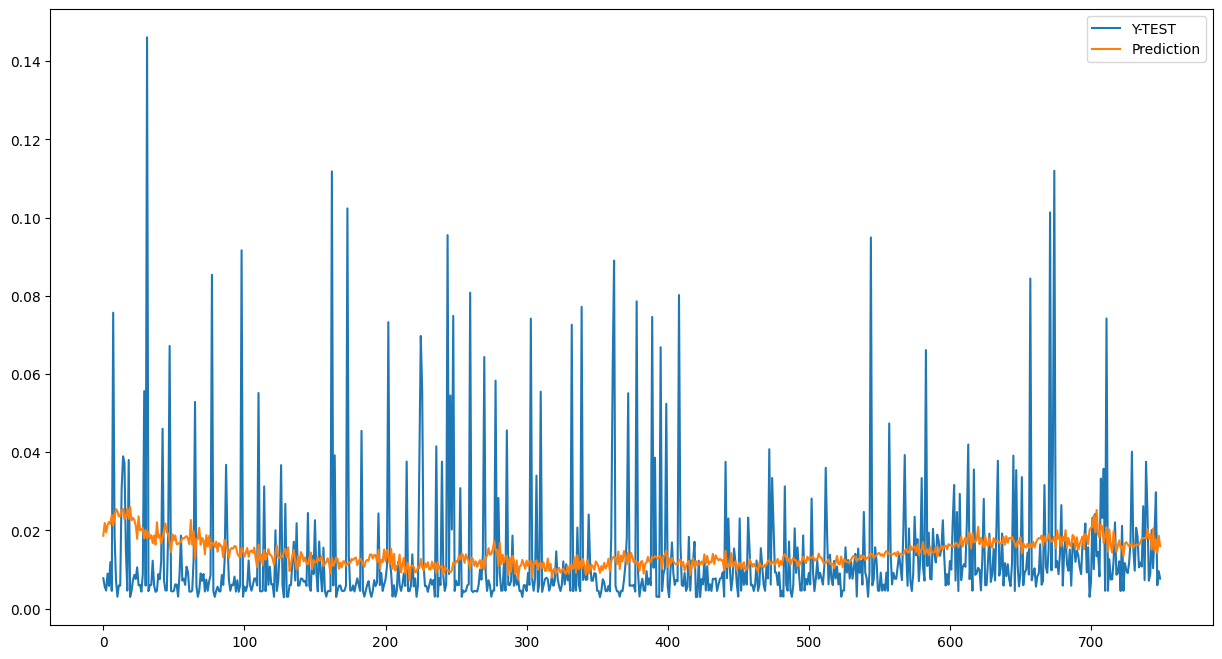

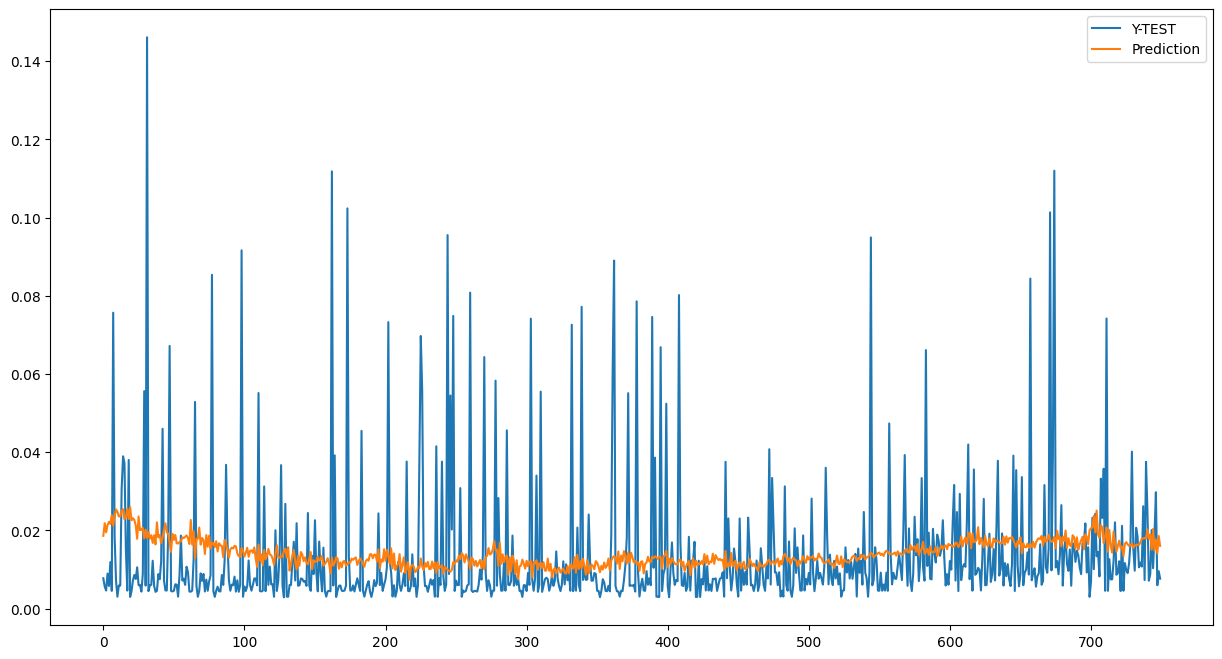

In [150]:
# Рисуем
for i in range(Ytest.shape[1]):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.savefig('foo10000.png')
  plt.show()

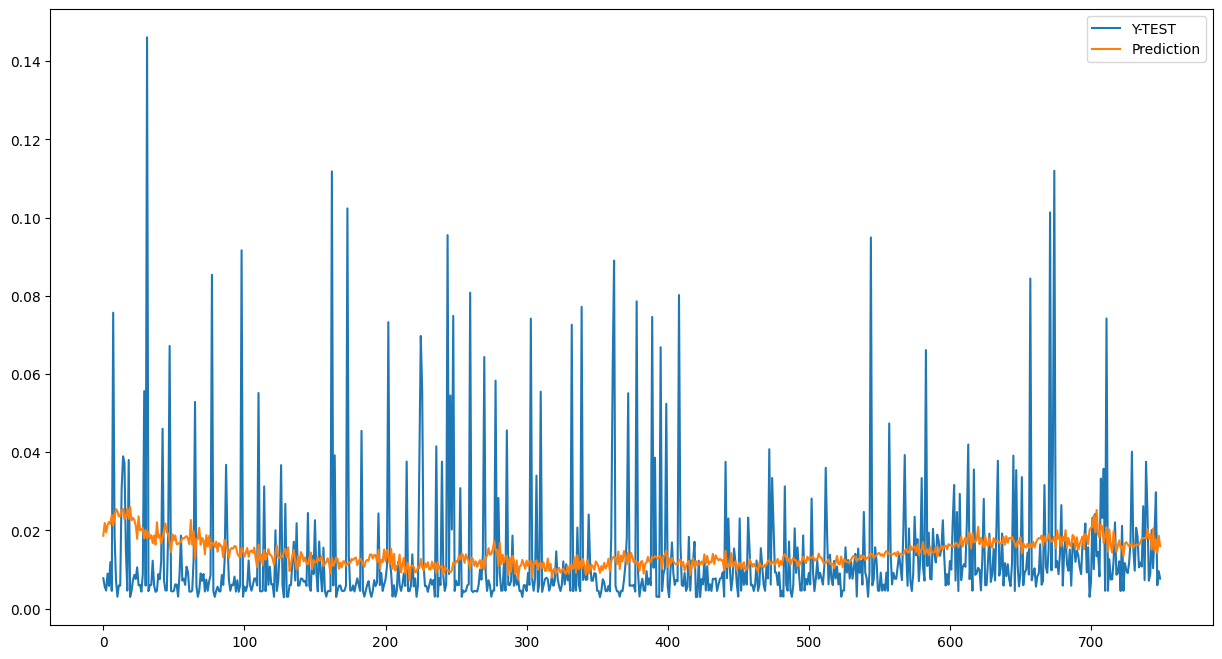

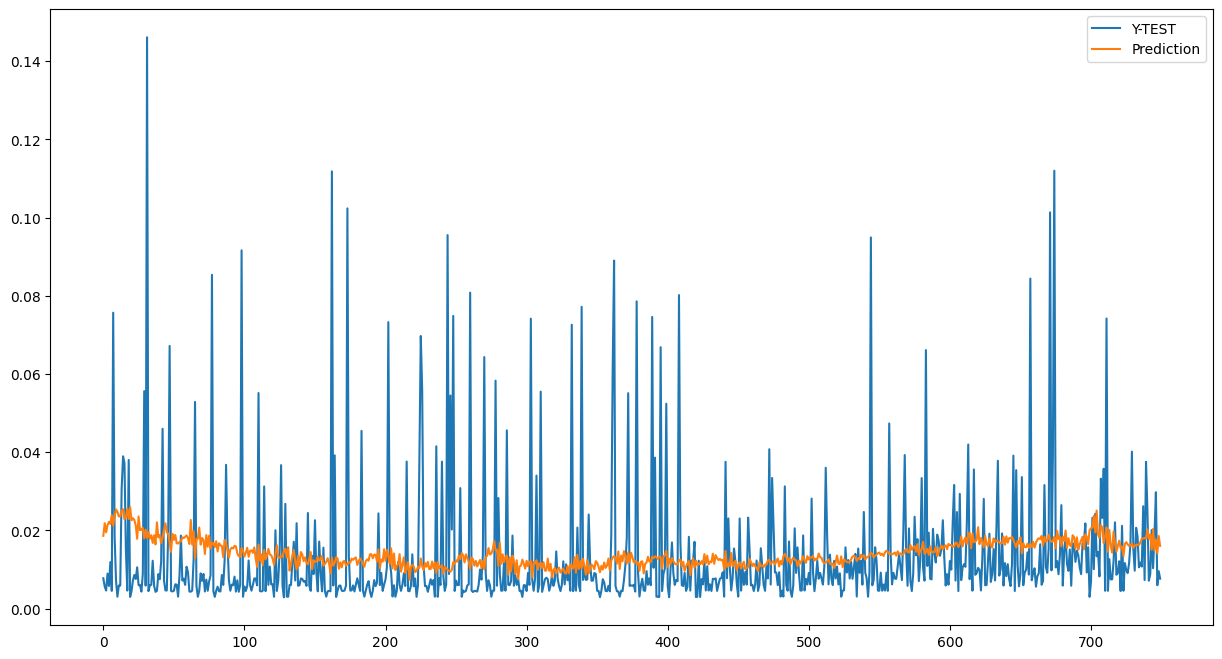

IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 1500x800 with 0 Axes>

In [151]:
for i in range(10):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.show()